<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
%matplotlib inline

import sys
import os

from gEcon.classes.model import gEconModel
import gEcon.plotting.plotting as gp
from gEcon.classes.time_aware_symbol import TimeAwareSymbol
from gEcon.shared.utilities import string_keys_to_sympy

sys.path.append('C:/Users/Jesse/Python Projects/PyMC Statespace/')
from pymc_statespace.filters import StandardFilter
from pymc_statespace.utils.solve_discrete_lyapunov import doubling_step

import sympy as sp
import pandas as pd
import numpy as np
import pymc as pm
import aesara
import aesara.tensor as at
import aesara.sparse as asm

import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}
rcParams.update(config)

In [3]:
model = gEconModel('GCN Files/RBC_complete.gcn', verbose=True, build_pymc=True)
model.steady_state()
model.solve_model()

Model Building Complete.
Found:
	9 equations
	9 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	6 parameters
		 4 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.

Steady state found! Sum of squared residuals is 1.8273223312346094e-30
Solution found, sum of squared residuals:  6.431134774067124e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [4]:
model.pymc_model

In [5]:
observed_vars = ['Y', 'L']
fake_data_all = model.simulate(simulation_length=120, n_simulations=1).T.droplevel(1)
fake_data = fake_data_all[observed_vars].copy()

k_observed = len(observed_vars)
k_states = model.n_variables
k_posdef = model.n_shocks
timesteps = fake_data.shape[0]

obs_noise = np.random.uniform(0.01, 0.15)
fake_data['L'] = fake_data['L'].add(np.random.normal(scale=obs_noise, size=timesteps))

In [6]:
import sympy as sp

def build_cache_dict(model):
    cache_dict = {}
    pymc_rvs = model.pymc_model.rvs_to_values
    rv_names= [rv.name for rv in pymc_rvs]
    
    for rv in pymc_rvs:
        name = rv.name
        if name in model.free_param_dict.keys():
            key = (name, sp.core.symbol.Symbol, (), 'floatX', ())
            cache_dict[key] = rv
    
    for var in model.free_param_dict.keys():
        if var not in rv_names:
            key = (var, sp.core.symbol.Symbol, (), 'floatX', ())
            cache_dict[key] = at.constant(model.free_param_dict[var], dtype=aesara.config.floatX)
        
    return cache_dict

def build_aesara_system_matrices(sparse_dict):
    matrices = []
    for i, d in enumerate(sparse_dict):
        M = asm.dense_from_sparse(asm.CSR(**d))
        matrices.append(M)
        
    return matrices

In [7]:
system = model.system_equations
variables = model.variables
shocks = model.shocks

ss_sub_dict = string_keys_to_sympy(model.steady_state_relationships)

A, B, C, D = [x.tolist() for x in model._perturbation_setup(return_F_matrices=True)]

In [8]:
import numpy as np
from sympy.printing.aesaracode import aesara_code
sparse_dicts = []
names = ['A', 'B', 'C', 'D']

cache_dict = build_cache_dict(model)

for name, matrix in zip(names, [A, B, C, D]):
    print(f'Processing matrix {name}')
    data = [aesara_code(value.subs(ss_sub_dict), cache=cache_dict) for row in matrix for (i, value) in enumerate(row) if value != 0]
    idxs = [i for row in matrix for (i, value) in enumerate(row) if value != 0]
    pointers = np.r_[[0], np.cumsum([sum([value != 0 for value in row]) for row in matrix])]
    
    sparse_dicts.append({'data':data, 'indices':idxs, 'indptr':pointers, 'shape':(len(matrix), len(matrix[0]))})
    
A, B, C, D = build_aesara_system_matrices(sparse_dicts)

Processing matrix A
Processing matrix B
Processing matrix C
Processing matrix D


In [9]:
from aesara.tensor.nlinalg import matrix_dot, matrix_inverse

MVN_CONST = at.log(2 * at.constant(np.pi, dtype='float64')) 

def cycle_step(A, B, B_hat, C, tol):
    n, _ = A.shape
    idx_0 = at.arange(n)
    idx_1 = idx_0 + n
    
    AC_tall = at.concatenate([A, C], axis=0)
    AC_wide = at.concatenate([A, C], axis=1)
    
    temp = matrix_dot(AC_tall, at.linalg.solve(B, at.eye(B.shape[0]), check_finite=False), AC_wide)
#     temp = matrix_dot(AC_tall, matrix_inverse(B), AC_wide)
    new_B = B - temp[idx_0, :][:, idx_1] - temp[idx_1, :][:, idx_0]
    new_A = -temp[idx_0, :][:, idx_0]
    new_C = -temp[idx_1, :][:, idx_1]
    new_B_hat = B_hat - temp[idx_1, :][:, idx_0]
    
    A_norm = at.linalg.norm(new_A, ord=1)
    C_norm = at.linalg.norm(new_C, ord=1)
    
    return (new_A, new_B, new_B_hat, new_C, A_norm, C_norm), scan_until((A_norm < tol) & (C_norm < tol))

In [10]:
k_filter = StandardFilter()

def kalman_likelihood(T, R, Q, H, Z, observed_data, model):
    with model:
        doubling_result, doubling_updates = aesara.scan(doubling_step,
                                                        outputs_info = [T, at.linalg.matrix_dot(R, Q, R.T)],
                                                        non_sequences=[tol],
                                                        n_steps=max_iter,
                                                        name='doubling_algo')

        _, P0 = doubling_result
        P0 = pm.Deterministic('P0', P0[-1])
        
        observed = at.as_tensor_variable(observed_data)
        results = k_filter.build_graph(observed, a0, P0, T, Z, R, H, Q)

        f_states, p_states, s_states, f_covariances, p_covariances, s_covariances, ll, ll_obs = results
        filtered_states = pm.Deterministic('filtered_states', f_states)
        filtered_covariances = pm.Deterministic('filtered_covariances', f_covariances)
        
    return ll

In [11]:
from aesara.scan.utils import until as scan_until

with model.pymc_model:
#     sigma_obs_L = pm.HalfNormal('sigma_obs_L', sigma=0.1)
#     sigma_obs_Y = pm.HalfNormal('sigma_obs_Y', sigma=0.1)
    a0 = at.zeros((model.n_variables, 1), dtype='float64')

    Z = at.set_subtensor(
        at.zeros((k_observed, model.n_variables))[np.arange(k_observed),
                                                  np.argwhere(np.array([x.base_name in observed_vars for x in model.variables])).ravel()],
        1.0)

    obs_noise = []

    if len(obs_noise) > 0:
        H_idxs = np.stack([np.flatnonzero(x.name.replace(
            'sigma_obs_', '') == np.array(observed_vars)) for x in obs_noise]).ravel()
        H = at.set_subtensor(
            at.zeros((k_observed, k_observed))[H_idxs, H_idxs],
            at.stack(obs_noise))
    else:
        H = at.zeros((k_observed, k_observed), dtype='float64')
#     H = at.as_tensor_variable(np.array([[1e-8]], dtype='float64'))

    shock_names = [x.base_name for x in model.shocks]
    shock_params = [
        x for x in model.pymc_model.rvs_to_values if x.name == 'sigma_epsilon']
    Q_idxs = np.stack([np.flatnonzero(x.name.replace(
        'sigma_', '') == np.array(shock_names)) for x in shock_params]).ravel()
    Q_idxs = [0]
    Q = at.set_subtensor(
        at.zeros((k_posdef, k_posdef))[Q_idxs, Q_idxs],
        at.stack(shock_params))

#     Q = at.zeros((1, 1), dtype='float64')

    tol = at.constant(1e-8, dtype='float64')
    max_iter = at.constant(100, dtype='int32')

    cycle_result, cycle_updates = aesara.scan(cycle_step,
                                              outputs_info=[
                                                  A, B, B, C, None, None],
                                              non_sequences=tol,
                                              n_steps=max_iter,
                                              name='cycle_reduction')

    _, _, B_hat_final, _, A_norm, C_norm = cycle_result
    B_hat_solved = B_hat_final[-1]

    nan_mask = at.isnan(B_hat_solved)
    pert_failure_flag = at.any(nan_mask) | at.ge(
        C_norm[-1], 1e-8) | at.ge(A_norm[-1], 1e-8)

    # If cycle_reduction fails, B_hat_solved comes back all NaN, and we don't want to use it to compute the LL function
    # Neverthles, Aesara insists on computing both branches of the switch, so we need to pass in somthing valid to avoid LinAlg errors.
    # Thus, replace it with the identity matrix if cycle_reduction failed.
    B_hat_solved = at.set_subtensor(B_hat_solved[nan_mask], 0.0) + at.eye(k_states) * pert_failure_flag

    #         T = -at.linalg.pinv(B_hat_solved).dot(A)
    T = -at.linalg.solve(B_hat_solved, A, check_finite=False)
    R = -at.linalg.solve(C.dot(T) + B, D, check_finite=False)

    resids = at.sqr(A + B.dot(T) + matrix_dot(C, T, T)).sum()
    pert_failure_flag = pert_failure_flag | at.ge(resids, 1e-8)

#         R = -at.linalg.pinv(C.dot(T) + B).dot(D)

    failure = pm.Deterministic('failure', pert_failure_flag)

    log_likelihood = at.switch(pert_failure_flag,
                               at.constant(-np.inf, dtype='float64'),
                               kalman_likelihood(T, R,
                                                 Q, H, Z, fake_data.astype(
                                                     'float64').values,
                                                 model.pymc_model))

    #     filtered_states = pm.Deterministic('filtered_states', states)
    #     filtered_cov = pm.Deterministic('filtered_covariance', covariances)
    likelihood = pm.Potential('likelihood', log_likelihood)

In [ ]:
with model.pymc_model:
    trace = pm.sample(init='jitter+adapt_diag_grad', 
                      jitter_max_retries=100,
                      cores=6, 
                      discard_tuned_samples=False)

<AxesSubplot:>

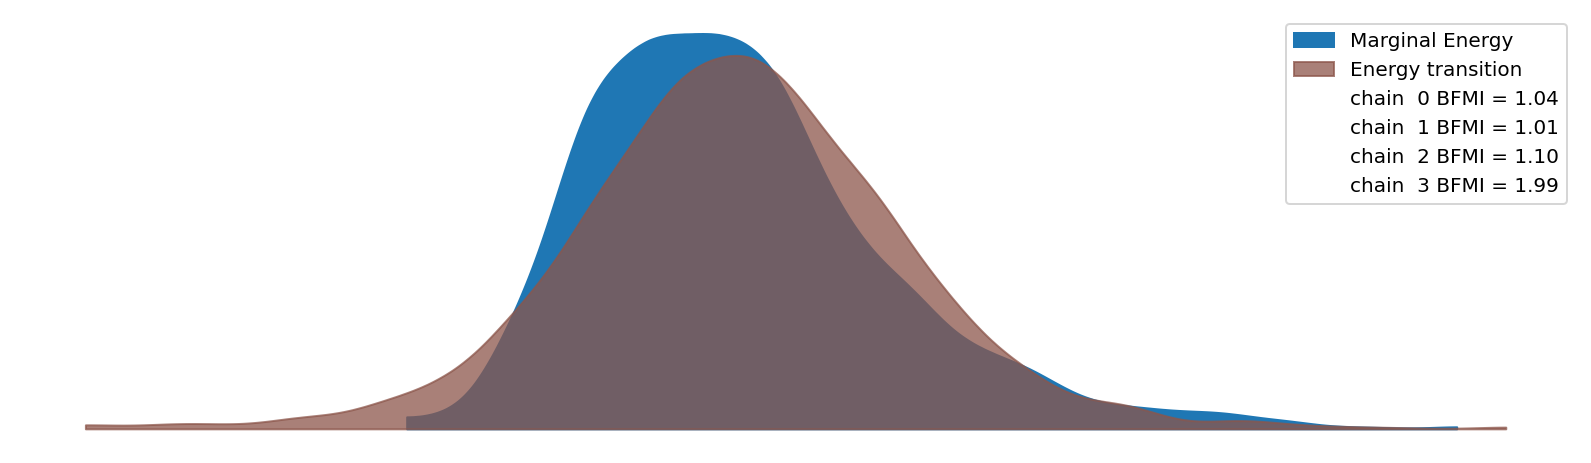

In [16]:
az.plot_energy(trace)

In [15]:
az.summary(trace, var_names=['sigma_C', 'sigma_L', 'alpha', 'rho_A', 'sigma_epsilon', 'failure'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_C,1.386,0.106,1.177,1.581,0.006,0.004,570.0,596.0,1.59
sigma_L,1.035,0.026,1.000,1.081,0.002,0.001,57.0,174.0,1.11
alpha,0.858,0.040,0.791,0.901,0.012,0.009,7.0,12.0,1.57
rho_A,0.821,0.034,0.759,0.890,0.001,0.001,656.0,763.0,1.60
sigma_epsilon,0.084,0.006,0.072,0.095,0.000,0.000,1334.0,1457.0,1.53
failure,0.054,0.225,0.000,0.000,0.035,0.025,41.0,41.0,1.10


IndexError: index 5 is out of bounds for axis 0 with size 5

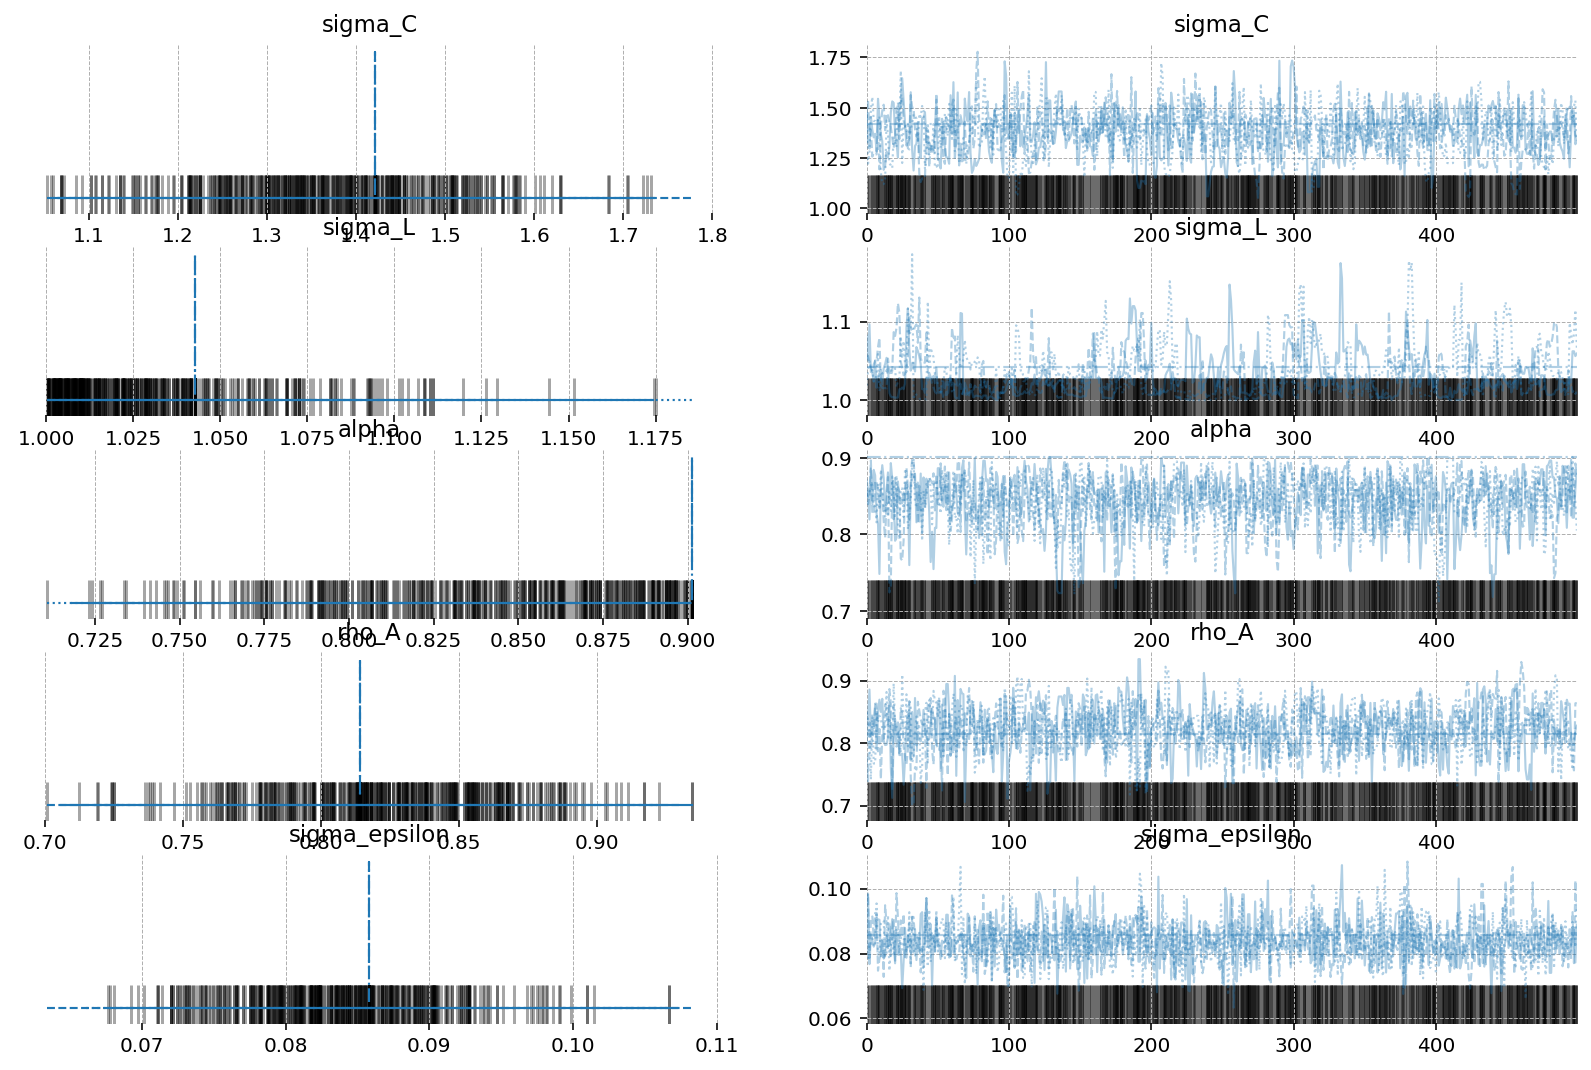

In [17]:
fig, ax = plt.subplots(5, 2, figsize=(14,9), dpi=144)
az.plot_trace(trace, var_names=['~filtered_states', '~filtered_covariances', '~P0'], axes=ax);
for axis in ax[:, 0]:
    xmin, xmax = axis.get_xlim()
    var = axis.get_title()
    if var in model.param_priors.keys():
        d = model.param_priors[var]
    else:
        d = model.shock_priors['epsilon_A'].rv_params['scale']
    axis.plot(x_grid := np.linspace(xmin, xmax, 100), d.pdf(x_grid), color='tab:orange')
fig.tight_layout()
plt.show()

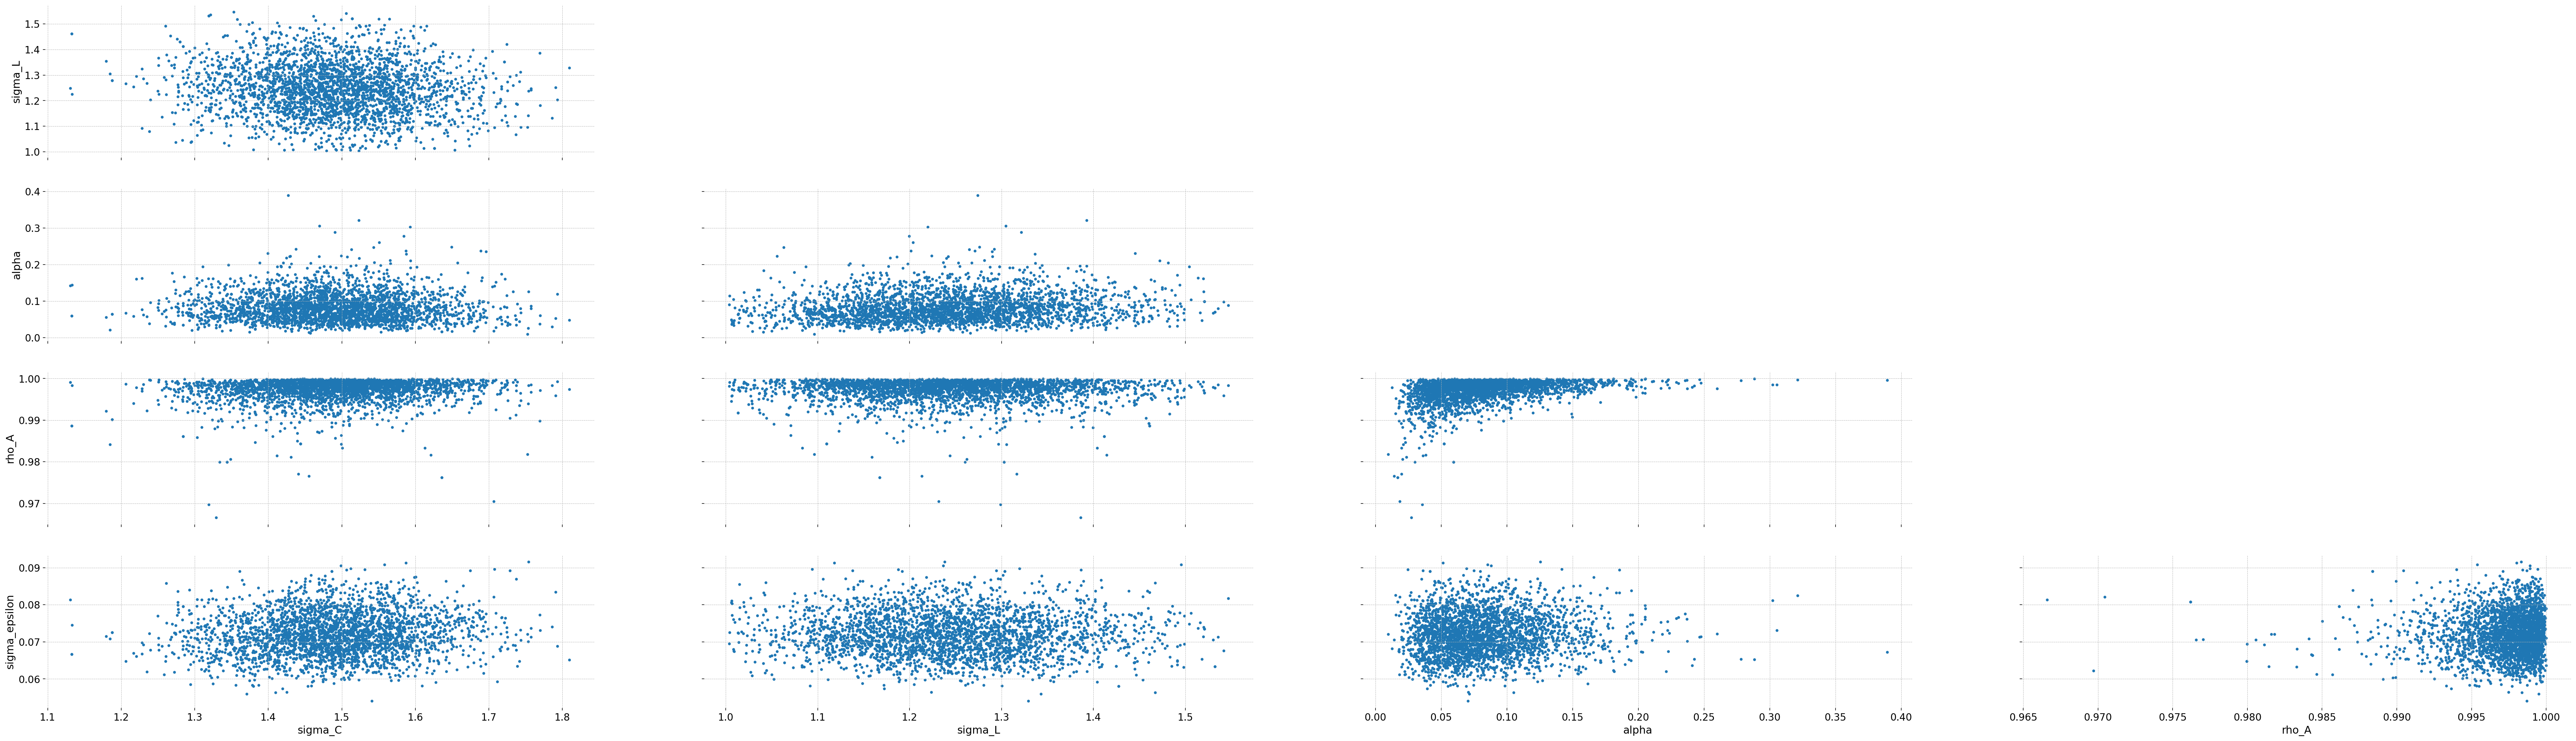

In [22]:
az.plot_pair(trace, var_names=['sigma_C', 'sigma_L', 'alpha', 'rho_A', 'sigma_epsilon'], divergences=True);